# Download Data

In [ ]:
!wget https://raw.githubusercontent.com/mmalekzadeh/motion-sense/master/data/data_subjects_info.csv
!wget -O A_DeviceMotion_data.zip https://github.com/mmalekzadeh/motion-sense/blob/master/data/A_DeviceMotion_data.zip?raw=true

In [ ]:
!unzip A_DeviceMotion_data.zip

# Process Data
Use script provided by [data source ](https://github.com/mmalekzadeh/motion-sense/blob/master/codes/0_import_dataset_and_creat_labeld_time_series.ipynb)

In [2]:
import numpy as np
import pandas as pd

##_____________________________

def get_ds_infos():
    ## 0:Code, 1:Weight, 2:Height, 3:Age, 4:Gender
    dss = np.genfromtxt("data_subjects_info.csv",delimiter=',')
    dss = dss[1:]
    print("----> Data subjects information is imported.")
    return dss
##____________

def creat_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes):
    dataset_columns = num_features+num_act_labels+num_gen_labels
    ds_list = get_ds_infos()
    train_data = np.zeros((0,dataset_columns))
    test_data = np.zeros((0,dataset_columns))
    for i, sub_id in enumerate(ds_list[:,0]):
        for j, act in enumerate(label_codes):
            for trial in trial_codes[act]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                unlabel_data = raw_data.values
                label_data = np.zeros((len(unlabel_data), dataset_columns))
                label_data[:,:-(num_act_labels + num_gen_labels)] = unlabel_data
                label_data[:,label_codes[act]] = 1
                label_data[:,-(num_gen_labels)] = int(ds_list[i,4])
                ## We consider long trials as training dataset and short trials as test dataset
                if trial > 10:
                    test_data = np.append(test_data, label_data, axis = 0)
                else:    
                    train_data = np.append(train_data, label_data, axis = 0)
    return train_data , test_data
#________________________________


print("--> Start...")
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
num_features = 12 # attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
num_act_labels = 6 # dws, ups, wlk, jog, sit, std
num_gen_labels = 1 # 0/1(female/male)
label_codes = {"dws":num_features, "ups":num_features+1, "wlk":num_features+2, "jog":num_features+3, "sit":num_features+4, "std":num_features+5}
trial_codes = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16], "sit":[5,13], "std":[6,14]}    
## Calling 'creat_time_series()' to build time-series
print("--> Building Training and Test Datasets...")
train_ts, test_ts = creat_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes)
print("--> Shape of Training Time-Seires:", train_ts.shape)
print("--> Shape of Test Time-Series:", test_ts.shape)

--> Start...
--> Building Training and Test Datasets...
----> Data subjects information is imported.
--> Shape of Training Time-Seires: (1081446, 19)
--> Shape of Test Time-Series: (331419, 19)


# Descriptive Analysis

Below is the provided training data with labels added for clarity.  

In [11]:
pd.DataFrame(train_ts, columns=["roll", "pitch", "yaw", "gravity.x", "gravity.y", "gravity.z", "rotation.x", "rotation.y", "rotation.z", "accel.x", "accel.y", "accel.z", "downstairs", "upstairs", "walk", "jog", "sit", "stand", "male"])

,roll,pitch,yaw,gravity.x,gravity.y,gravity.z,rotation.x,rotation.y,rotation.z,accel.x,accel.y,accel.z,downstairs,upstairs,walk,jog,sit,stand,male
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081441,0.024580,-1.445235,-1.865114,0.003078,0.992127,-0.125194,0.019392,-0.421634,0.119275,0.068257,0.011260,0.003077,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1081442,0.035625,-1.444928,-1.845826,0.004471,0.992089,-0.125457,0.004552,-0.397094,0.122345,0.072540,0.021796,0.010146,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1081443,0.047078,-1.444934,-1.826624,0.005908,0.992090,-0.125392,-0.010243,-0.363271,0.117955,0.037656,0.017767,0.002650,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1081444,0.058243,-1.445177,-1.808854,0.007293,0.992120,-0.125076,-0.022710,-0.300329,0.106037,0.026124,0.014288,-0.002594,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<BarContainer object of 6 artists>

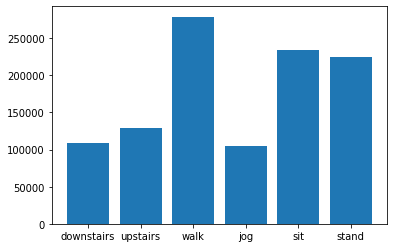

In [24]:
import matplotlib.pyplot as plt

occurences = np.sum(train_ts[:,12:18], axis=0)
x = ["downstairs", "upstairs", "walk", "jog", "sit", "stand"]

plt.bar(x, occurences)  # plot class occurences in data set



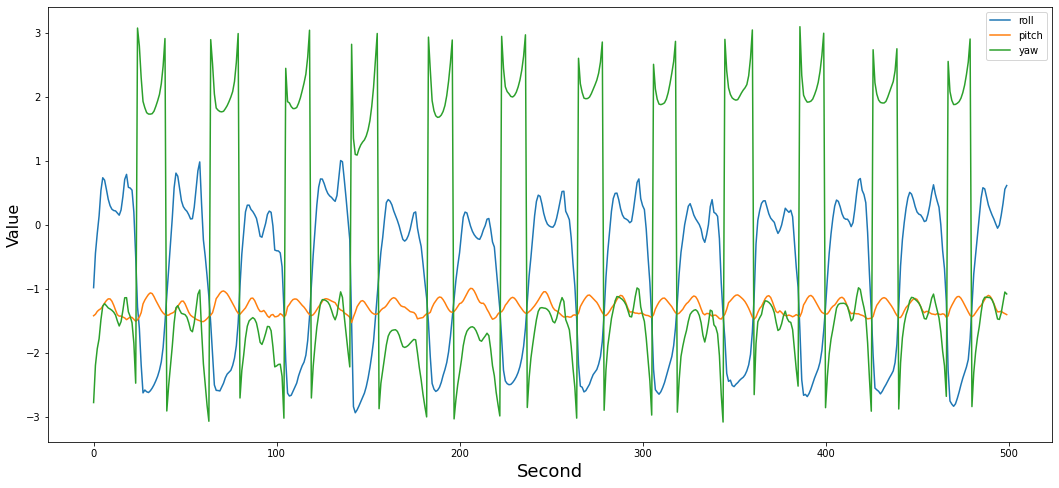

In [25]:
# plot jogging movement over time from provided code

## male
data = train_ts[train_ts[:,-1]==1]
## jogging
data = data[data[:,-4]==1]
## 10 seconds
data = pd.DataFrame(data[10000:10500,0:3])
data.plot()
plt.xlabel('Second', fontsize=18)
plt.ylabel('Value', fontsize=16)
lgnd=plt.legend()
lgnd.get_texts()[0].set_text('roll')
lgnd.get_texts()[1].set_text('pitch')
lgnd.get_texts()[2].set_text('yaw')
fig = pyplt.gcf()
fig.set_size_inches(18, 8)
plt.show()

Now we attempt dimensonality reduction with PCA.  

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X = train_ts[:,0:11]  # extract data columns for principle component analysis


# Normalize
scl = StandardScaler()
scaled_X = scl.fit_transform(X)

# Reduce dimensions before feeding into tsne
pca = PCA(n_components=0.9, random_state=3)
pca_transformed = pca.fit_transform(scaled_X)

# Transform data
colors = ['r','g','b','c','m','y','k']
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(pca_transformed)

tsne_transformed

# for color, in zip(colors, range(6)):
#     plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=2)